# Вычислительная математика
## Приближение функций

Иван Цыбулин, Ярослав Холодов


Задача интерполяции состоит в том, чтобы приблизить заданную функцию $f(x)$ другой функцией $P(x)$ из некоторого класса, так, чтобы в заданных узлах $x_k$ они совпадали
$$
f(x_k) = P(x_k)
$$

### Виды интерполяции

Интерполяция может быть 
* алгебраической: $P(x)$ &mdash; полином заданной степени
* тригонометрической: $P(x)$ &mdash; ряд Фурье
$$
P(x) = a_0 + a_1 \cos x + b_1 \sin x + a_2 \cos 2x + b_2 \sin 2x \dots
$$
* сплайновой: кусочно-полиномиальная

### Сведение к СЛАУ

$$
P(x_1) = c_0 + c_1 x_1 + c_2 x_1^2 + \dots = f(x_1)\\
P(x_2) = c_0 + c_1 x_2 + c_2 x_2^2 + \dots = f(x_2)\\
\vdots\\
P(x_n) = c_0 + c_1 x_n + c_2 x_n^2 + \dots = f(x_n)
$$

Неизвестными параметрами интерполирующего многочлена $P(x)$ являются его коэффициенты. Относительно них система является линейной и разрешима, если количество уравнений = количеству неизвестных.

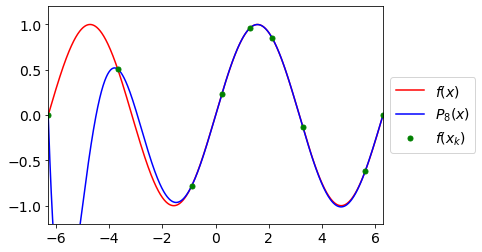

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', **{'size' : 14})

n = 9
h = 0.2 + np.random.rand(n)
x = np.cumsum(h)
x -= x[0]
x /= x[-1]
a = 2 * np.pi
x = a * (2 * x - 1)

def f(x):
    return np.sin(x)
fv = f(x)

W = np.empty((n, n))
for k in range(n):
    W[:, k] = x**k
c = np.linalg.solve(W, fv)

X = np.linspace(-a, a, 1000)
P = lambda x: np.polyval(list(reversed(c)), x)

plt.plot(X, f(X), 'r', label='$f(x)$')
plt.plot(X, P(X), 'b', label='$P_{%d}(x)$' % (n-1))
plt.plot(x, fv, 'g.', ms=10, label='$f(x_k)$')
plt.axis([-a, a, -1.2, 1.2])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Способы построение интерполяционного многочлена
Существуют способы построение интерполяционного многочлена, не требующие решения системы линейных уравнений
* Интерполяционный многочлен в форме Ньютона
* Интерполяционный многочлен в форме Лагранжа

При этом интерполяционный многочлен остается одним и тем же (он единственный!), изменяется лишь форма его представления.

### Интерполяционный многочлен в форме Ньютона
Интерполяционный многочлен в форме Ньютона имеет вид
$$
P_{n-1}(x) = f(x_1) + f(x_1, x_2) (x - x_1) + f(x_1, x_2, x_3) (x - x_1) (x - x_2) + \dots \\
\dots + f(x_1, \dots, x_n) (x - x_1) \cdots (x - x_{n-1})
$$
Величины $f(x_1, x_2), f(x_1, x_2, x_3), \dots$ называются *разделенными разностями*.

### Разделенные разности
Порядком разделенной разности $f(x_i, \dots, x_{i+k})$ называется число аргументов без единицы ($k$). Разделенные разности нулевого порядка $f(x_i)$ совпадают со значениями функции $f(x_i)$ (путаницы в обозначениях нет)

Разделенная разность порядка $k+1$ определяется через разделенные разности порядка $k$:
$$
f(\color{red}{x_{i}}, \dots, \color{blue}{x_{i+k+1}}) = \frac{f(x_{i+1}, \dots, \color{blue}{x_{i+k+1}}) - f(\color{red}{x_{i}}, \dots, x_{i+k})}{\color{blue}{x_{i+k+1}} - \color{red}{x_{i}}}
$$

Разделенные разности удобно вычислять в таблице

$x_i$ | $f(x_i)$ | $f(x_i, x_{i+1})$ | $f(x_i, x_{i+1}, x_{i+2})$
------|----------|-------------------|---------------------------
$1$ | $\color{red}{1}$ | |
| | $\color{green}{2}$|
$2$ | $3$ | | $\color{blue}{-1}$
| | $-1$|
$4$ | $1$ | |

$$
P(x) = \color{red}{1} + \color{green}{2} (x - 1) \color{blue}{-1} (x-1)(x-2)
$$

In [4]:
def divided_differences(x, f):
    n = len(x);
    F = np.empty((n, n))
    F[:, 0] = f
    for k in range(1, n):
        F[0:n-k, k] = (F[1:n-k+1, k-1] - F[0:n-k, k-1]) / (x[k:] - x[:-k])
    return F # F[i, k] = f(x_i, x_{i+1}, ..., x_{i+k})

x = np.array([1, 2, 4, 5])
f = np.array([1, 3, 1, 3])
F = divided_differences(x, f)
print(F)

[[  1.00000000e+000   2.00000000e+000  -1.00000000e+000   5.00000000e-001]
 [  3.00000000e+000  -1.00000000e+000   1.00000000e+000   1.73383010e-316]
 [  1.00000000e+000   2.00000000e+000   6.91364661e-310   0.00000000e+000]
 [  3.00000000e+000   6.91364663e-310   0.00000000e+000   0.00000000e+000]]


### Интерполяционные многочлены в форме Лагранжа
Рассмотрим вспомогательную задачу. Построим интерполяционный многочлен для функции
$f_k(x_i) = \delta_{ik} = \begin{cases}1, &x_i = x_k\\ 0, &x_i \neq x_k\end{cases}$

Этот многочлен имеет вид
$$
\ell_k(x) = \frac{(x - x_1)\cdots(x-x_{k-1})(x-x_{k+1}) \cdots (x-x_n)}{
(x_k - x_1)\cdots(x_k-x_{k-1})(x_k-x_{k+1}) \cdots (x_k-x_n) 
} = \prod_{i\neq k}\frac{x-x_i}{x_k-x_i}
$$
Данный многочлен называется *базисным интерполяционным многочленом Лагранжа*

После построения базисных интерполяционных многочленов интерполянт записывается особенно просто
$$
P(x) = \sum_{k=1}^n f(x_k)\ell_k(x)
$$
Хорошо видно, что от $x$ зависят лишь базисные многочлены, а от $f$ &mdash; лишь коэффициенты разложения по этим многочленам.

### Ошибка интерполяции
Важный вопрос &mdash; насколько $P(x)$ и $f(x)$ различаются? Очевидно, что в узлах $x_k$ они совпадают, но что происходит в промежутках?

Верна теорема
$$
|f(x) - P(x)| \leqslant \frac{|f^{(n)}(\xi)|}{n!} |\omega(x)|,
$$
где
$$
\omega(x) = (x - x_1) (x - x_2) \cdots (x - x_n).
$$

$$
\varepsilon_\text{метод} = |f(x) - P(x)| \leqslant \frac{|f^{(n)}(\xi)|}{n!} |\omega(x)|,\\
\omega(x) = (x - x_1) (x - x_2) \cdots (x - x_n),
$$
Первый сомножитель можно оценить как $\frac{M_n}{n!}$, то есть величиной, зависящей лишь от функции, а второй сомножитель $|\omega(x)|$ зависит лишь от расположения узлов, но не от самой функции.

### Феномен Рунге
Оказывается, что увеличение количества узлов интерполяции не гарантирует улучшения приближения функции. Пример
$$
f(x) = \frac{1}{1 + 25 x^2}, \qquad x \in [-1, 1]
$$
Будем проводить интерполяцию этой функции на равномерной сетке с числом узлов $n = 5, 10, 15, 20$

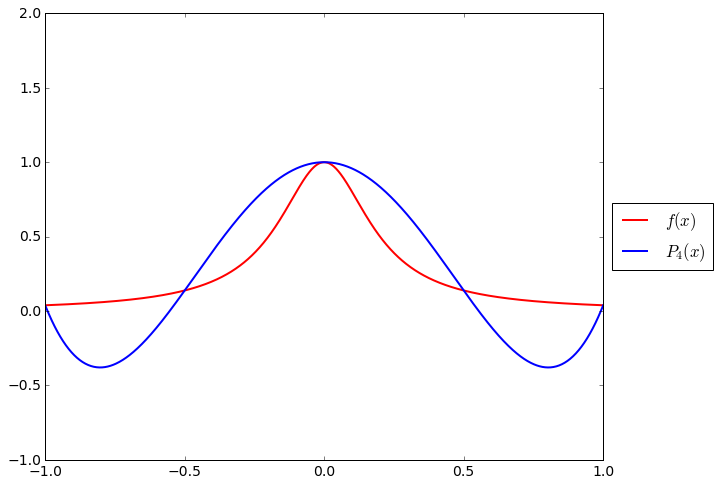

In [7]:
def runge(x):
    return 1 / (1 + 25 * x**2)

X = np.linspace(-1, 1, 1000)

plt.figure(figsize=(10, 8))
plt.plot(X, runge(X), 'r', label='$f(x)$', lw=2)
n = 5
x = np.linspace(-1, 1, n)
F = divided_differences(x, runge(x))
plt.plot(X, evaluate(x, F, X), label='$P_{%d}(x)$' % (n-1), lw=2)
plt.axis([-1, 1, -1, 2]); 
plt.legend(loc='center left', bbox_to_anchor=(1, .5)); plt.show()

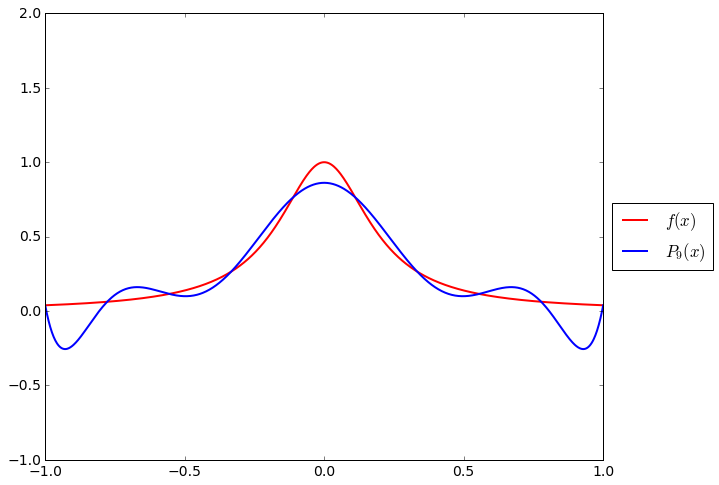

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(X, runge(X), 'r', label='$f(x)$', lw=2)
n = 10
x = np.linspace(-1, 1, n)
F = divided_differences(x, runge(x))
plt.plot(X, evaluate(x, F, X), label='$P_{%d}(x)$' % (n-1), lw=2)
plt.axis([-1, 1, -1, 2]); 
plt.legend(loc='center left', bbox_to_anchor=(1, .5)); plt.show()

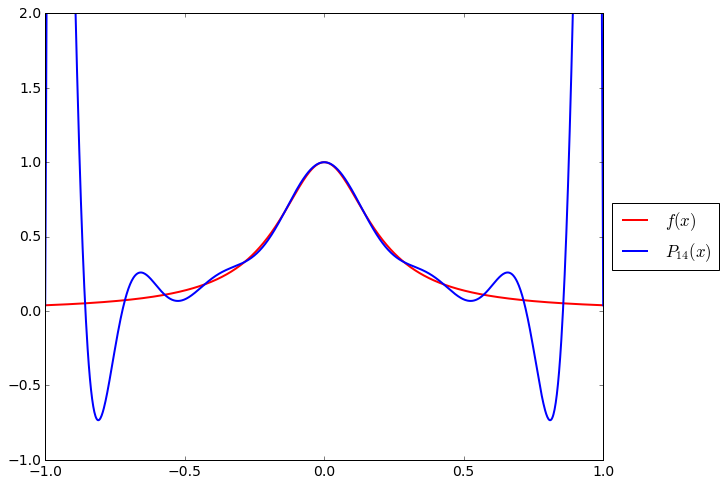

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(X, runge(X), 'r', label='$f(x)$', lw=2)
n = 15
x = np.linspace(-1, 1, n)
F = divided_differences(x, runge(x))
plt.plot(X, evaluate(x, F, X), label='$P_{%d}(x)$' % (n-1), lw=2)
plt.axis([-1, 1, -1, 2]); 
plt.legend(loc='center left', bbox_to_anchor=(1, .5)); plt.show()

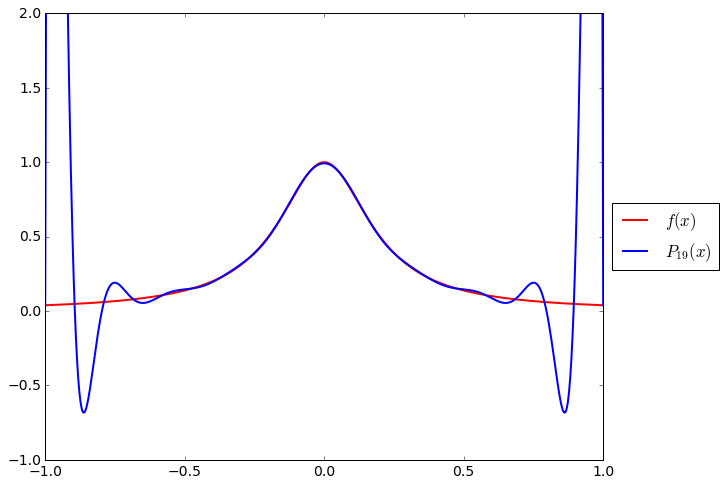

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(X, runge(X), 'r', label='$f(x)$', lw=2)
n = 20
x = np.linspace(-1, 1, n)
F = divided_differences(x, runge(x))
plt.plot(X, evaluate(x, F, X), label='$P_{%d}(x)$' % (n-1), lw=2)
plt.axis([-1, 1, -1, 2]); 
plt.legend(loc='center left', bbox_to_anchor=(1, .5)); plt.show()

### Оптимальное расположение узлов
Изучим, насколько сильно можно уменьшить ошибку интерполяции, если грамотно выбирать узлы интерполяции.

Рассмотрим функцию $\omega(x) = (x - x_1) \cdots (x - x_n)$. На равномерной сетке она сильно растет к краям отрезка:
    

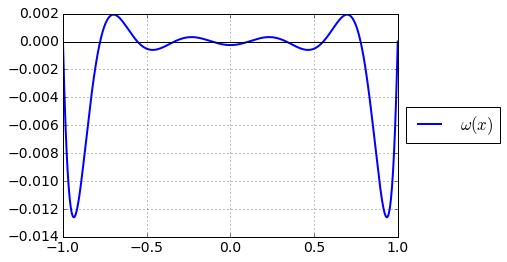

In [11]:
X = np.linspace(-1, 1, 1000)
x = np.linspace(-1, 1, 10)
omega = (X - x[0]);
for i in range(1, len(x)):
    omega *= (X - x[i])
plt.plot(X, omega, 'b', lw=2, label='$\omega(x)$')
plt.plot(X, 0*X, 'k')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1,.5)); plt.show()

### Чебышевские узлы
Если выбрать узлы интерполяции в корнях многочлена Чебышева
$$
x_k = \frac{a+b}{2} + \frac{b-a}{2} \cos\left(\frac{2k-1}{2n}\pi\right),
$$
то функция $\omega(x)$ ведет себя как многочлен Чебышева:

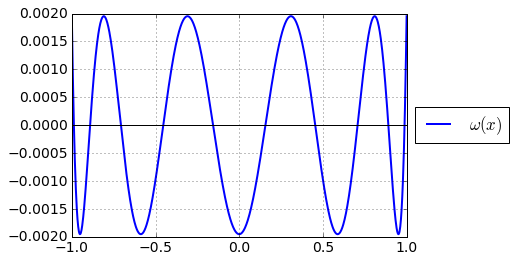

In [12]:
X = np.linspace(-1, 1, 1000)
x = np.cos((2*np.arange(10)+1) / 20 * np.pi)
omega = (X - x[0]);
for i in range(1, len(x)):
    omega *= (X - x[i])
plt.plot(X, omega, 'b', lw=2, label='$\omega(x)$')
plt.plot(X, 0*X, 'k')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1,.5)); plt.show()

Доказано, что в случае выбра Чебышевских узлов интерполяции последовательность интерполяционных многочленов $P_n(x)$ будет сходиться к $f(x)$ *равномерно*, если $f(x)$ имеет ограниченную первую производную.

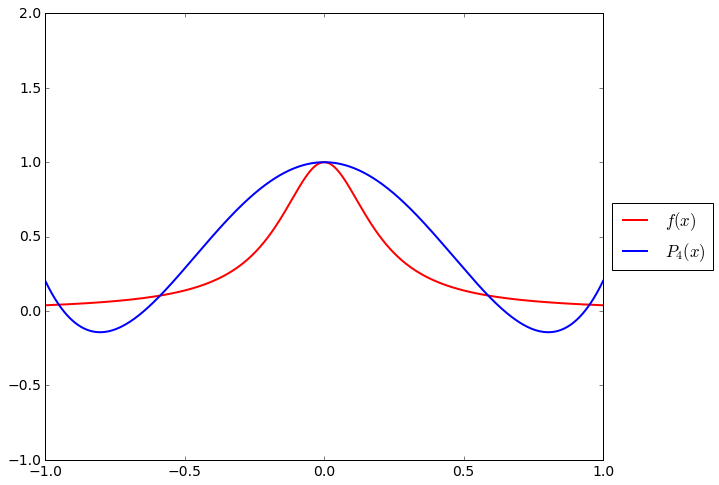

In [13]:
def runge(x):
    return 1 / (1 + 25 * x**2)

X = np.linspace(-1, 1, 1000)

plt.figure(figsize=(10, 8))
plt.plot(X, runge(X), 'r', label='$f(x)$', lw=2)
n = 5
x = np.cos((np.arange(n)*2+1) / (2*n) * np.pi)
F = divided_differences(x, runge(x))
plt.plot(X, evaluate(x, F, X), label='$P_{%d}(x)$' % (n-1), lw=2)
plt.axis([-1, 1, -1, 2]); 
plt.legend(loc='center left', bbox_to_anchor=(1, .5)); plt.show()

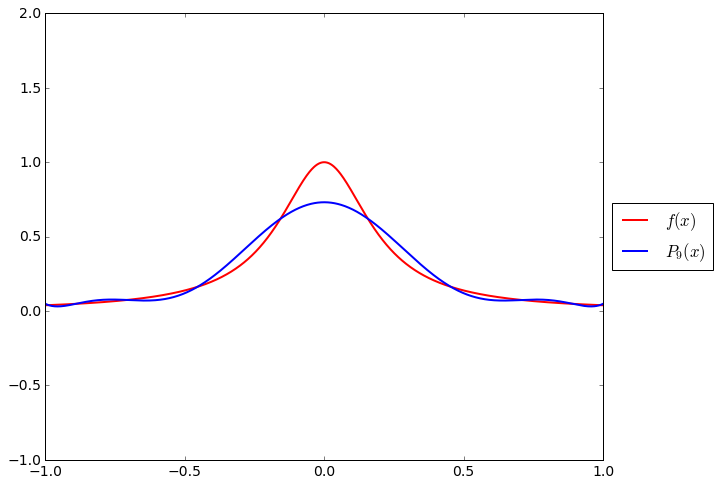

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(X, runge(X), 'r', label='$f(x)$', lw=2)
n = 10
x = np.cos((np.arange(n)*2+1) / (2*n) * np.pi)
F = divided_differences(x, runge(x))
plt.plot(X, evaluate(x, F, X), label='$P_{%d}(x)$' % (n-1), lw=2)
plt.axis([-1, 1, -1, 2]); 
plt.legend(loc='center left', bbox_to_anchor=(1, .5)); plt.show()

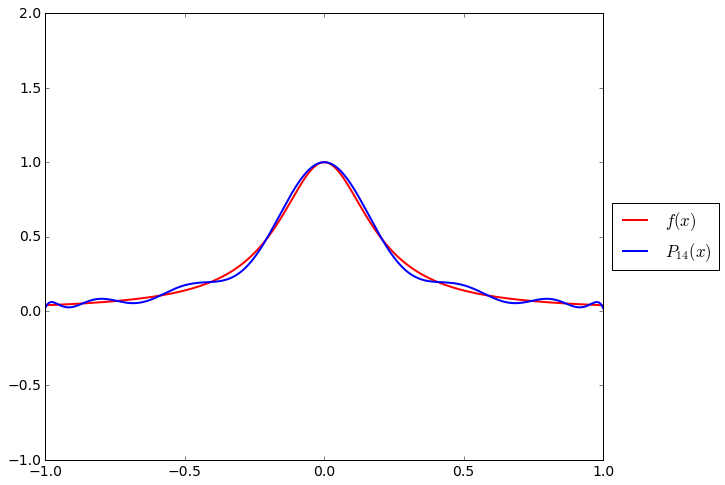

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(X, runge(X), 'r', label='$f(x)$', lw=2)
n = 15
x = np.cos((np.arange(n)*2+1) / (2*n) * np.pi)
F = divided_differences(x, runge(x))
plt.plot(X, evaluate(x, F, X), label='$P_{%d}(x)$' % (n-1), lw=2)
plt.axis([-1, 1, -1, 2]); 
plt.legend(loc='center left', bbox_to_anchor=(1, .5)); plt.show()

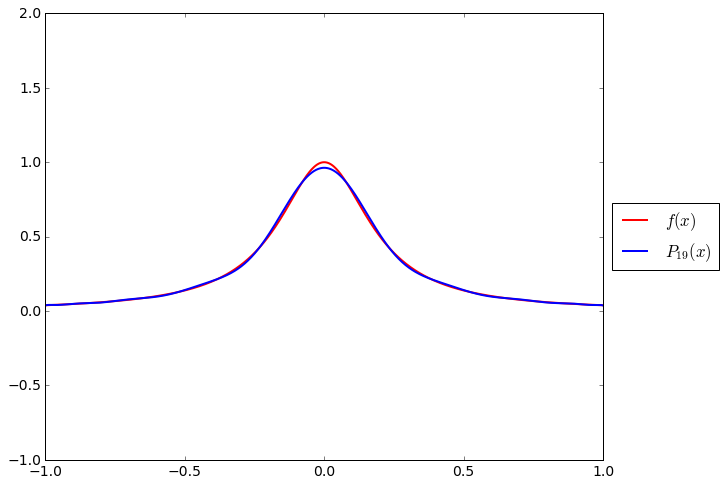

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(X, runge(X), 'r', label='$f(x)$', lw=2)
n = 20
x = np.cos((np.arange(n)*2+1) / (2*n) * np.pi)
F = divided_differences(x, runge(x))
plt.plot(X, evaluate(x, F, X), label='$P_{%d}(x)$' % (n-1), lw=2)
plt.axis([-1, 1, -1, 2]); 
plt.legend(loc='center left', bbox_to_anchor=(1, .5)); plt.show()

### Чувствительность интерполяции

До сих пор мы считали, что значения функции $f(x)$ в узлах интерполяции заданы точно. На практике в значениях $f(x)$ присутствуют ошибки, свзяанные, например, с погрешностью измерения функции $f(x)$. В любом случае, при представлении в вычислительной технике $f(x_i)$ всегда содержит ошибку округления.

Для исследования чувствительности интерполяции удобно записывать интерполяционный многочлен в форме Лагранжа
$$
P(x) = \sum_{i=1}^n f(x_i)\ell_i(x).
$$

При возмущении значений в узлах на $\Delta f(x_i)$ интерполяционный многочлен изменяется
$$
\tilde P(x) = \sum_{i=1}^n \left[f(x_i) + \Delta f(x_i)\right]\ell_i(x).
$$

### Ошибка чувствительности интерполяции

Разность $|\tilde P(x) - P(x)|$ будем называть *ошибкой чувствительности интерполяции*
$$
|\tilde P(x) - P(x)| = \left|\sum_{i=1}^n \Delta f(x_i) \ell_i(x)\right|.
$$
Предположим, что все $|\Delta f(x_i)| \leqslant \Delta f$. Тогда
$$
|\tilde P(x) - P(x)| \leqslant \Delta f \sum_{i=1}^n |\ell_i(x)|.
$$
Функция $L(x) = \sum_{i=1}^n |\ell_i(x)|$ называется функцией Лебега и зависит только от расположения узлов.

### Функция Лебега
Заметим, что
$$
L(x) = \sum_{i=1}^n |\ell_i(x)| \geqslant \left|\sum_{i=1}^n \ell_i(x)\right| = 1.
$$


Величина $L = \max_{x \in [a,b]} L(x)$ называется константой Лебега.

### Рост констант Лебега

Для *равномерной* сетки константа Лебега зависит только от числа узлов
* Для линейной интерполяции ($n = 2$) константа Лебега $L = 1$.
* Для квадратичной интерполяции ($n = 3$) константа Лебега $L = 1.25$.
* При $n = 10$ константа Лебега $L \approx 19$.
* При $n = 20$ константа Лебега $L \approx 6900$.
* При $n = 30$ константа Лебега $L \approx 4 \cdot 10^6$.
* При $n \gg 1$ константа Лебега растет как $L \sim \frac{2^n}{e (n-1) \ln (n-1)}$

Напротив, для сетки из нулей многочлена Чебышева (которая минимизирует ошибку интерполяции), константа Лебега оказывается довольно малой:

* Для линейной интерполяции ($n = 2$) константа Лебега $L = \sqrt{2}$.
* Для квадратичной интерполяции ($n = 3$) константа Лебега $L = 5/3 \approx 1.6667$.
* При $n = 10$ константа Лебега $L \approx 2.4288$.
* При $n = 20$ константа Лебега $L \approx 2.8698$.
* При $n = 30$ константа Лебега $L \approx 3.1278$.
* В общем случае $\frac{2}{\pi} \ln n + 0.96 < L < \frac{2}{\pi} \ln n + 1$

### Сплайн-интерполяция
При интерполяции единым многочленом для большой равномерной сетки возникают проблемы
* Интерполяционный многочлен не обязан хорошо приближать функцию (пример Рунге).
* Интерполянт чувствителен к погрешностям в узлах, при $n > 50$ не хватает даже машинной точности.

Данные проблемы решаются переходом к кусочно-многочленным интерполянтам &mdash; сплайнам.

### Сплайн
Для сетки $[x_0, x_1, \dots, x_n]$ сплайн задается в виде $n$ функций $s_i(x)$:
$$
s(x) = s_i(x), \; x \in [x_{i-1}, x_i], \qquad i = 1, 2, \dots, n.
$$
В узлах интерполяции $x_i$ сплайн принимает заданные значения $f(x_i)$:
$$
s(x_i) = s_i(x_i) = s_{i+1}(x_i) = f(x_i)
$$

### Характеристики сплайна
Сплайн характеризуется следующими параметрами:
* Степень &mdash; это степень многочленов $s_i(x)$
* Гладкость &mdash; это количество непрерывных производных у $s(x)$
* Дефект &mdash; это разность между степенью и гладкостью.

Легко показать, что условие &laquo;дефект = 0&raquo; приводит к тому, что все $s_i(x)$ совпадают, а сплайн превращается в интерполяционный многочлен.

### Кусочно линейная аппроксимация
Простейший сплайн имеет степень 1 и гладкость 0 &mdash; это приближение функции кусочно-линейной ломанной:

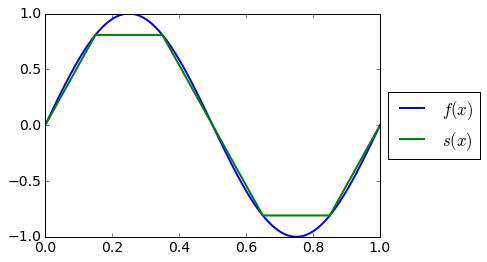

In [48]:
x = np.linspace(0, 1, 1000)
xs = np.array([0, 0.15, 0.35, 0.65, 0.85, 1])
plt.plot(x, np.sin(2*np.pi*x), lw=2, label='$f(x)$')
plt.plot(xs, np.sin(2*np.pi*xs), lw=2, label='$s(x)$')
plt.legend(loc='center left', bbox_to_anchor=(1, .5))
plt.show()

## Кубический сплайн дефекта 1
Каждая функция $s_i(x)$ определяется черырьмя параметрами
$$
s_i(x) = a_i + b_i(x - x_i) + \frac{c_i}{2} (x - x_i)^2 + \frac{d_i}{6} (x - x_i)^3,\\
a_i = s_i(x_i), \;\;
b_i = s_i'(x_i), \;\;
c_i = s_i''(x_i), \;\;
d_i = s_i'''(x_i).
$$

На данный сплайн наложены условия ($4n-2$ штуки)
$$
s_i(x_{i-1}) = f(x_{i-1}),\;\; s_i(x_i) = f(x_i), \quad i = 1, 2, \dots, n\\
s_i'(x_i) = s_{i+1}'(x_{i}),\;\; s_i''(x_i) = s_{i+1}''(x_{i}), \quad i = 1, 2, \dots, n-1
$$

### Граничные условия для сплайна
У сплайна остаются два свободных параметра, их определяют из различных граничных условий, например
* $s_1'(x_0) = f'(x_0),\;\; s_n'(x_n) = f'(x_n)$
* $s_1''(x_0) = f''(x_0),\;\; s_n''(x_n) = f''(x_n)$
* «Естественный» сплайн: $s_1''(x_0) = s_n''(x_n) = 0$

### Построение сплайна
Существует несколько способов определения функций $s_i(x)$ для кубического сплайна, все они сводят задачу к решению трехдиагональной системы. 

Рассмотрим вспомогательную задачу: определить $s_i(x)$ из условий
$$
s_i(x_{i-1}) = f_{i-1}\\
s_i(x_{i}) = f_{i}\\
s_i'(x_{i-1}) = m_{i-1}\\
s_i'(x_{i}) = m_{i}
$$
Эта задача называется задачей Эрмитовой интерполяции.

### Эрмитов элемент
Решая задачу построения кубического сплайна Эрмита, получаем
$$
s_i(x) = f_i + m_i(x - x_i) + \frac{2m_i + m_{i-1} - 3f(x_{i-1},x_i)}{x_i - x_{i-1}}(x-x_i)^2+\frac{m_i + m_{i-1} - 2f(x_{i-1},x_i)}{(x_i - x_{i-1})^2}(x-x_i)^2
$$

Составляя сплайн из Эрмитовых элементов мы сразу можем обеспечить непрерывность первой производной, задавая $m_i$ в каждом узле. Сами значения $m_i$ ($n+1$ штука) нужно определить из условия непрерывности второй производной и граничных условий.

### Система для $m_i$
Условие $s_i''(x_i) = s_{i+1}''(x_i)$ для соседних Эрмитовых элементов превращается в
$$
\frac{2m_i + m_{i-1} - 3f(x_{i-1},x_i)}{h_{i-1/2}} = 
-\frac{2m_i + m_{i+1} - 3f(x_i,x_{i+1})}{h_{i+1/2}}\\
\frac{m_{i-1}}{h_{i-1/2}} + 
\left(
\frac{2}{h_{i-1/2}} +
\frac{2}{h_{i+1/2}}
\right)m_i +
\frac{m_{i+1}}{h_{i+1/2}}
= 3 \left(
\frac{f(x_{i-1},x_i)}{h_{i-1/2}} + 
\frac{f(x_i,x_{i+1})}{h_{i+1/2}}
\right),
$$
что является трехдиагональной системой при $i = 1, \dots, n-1$. Здесь $h_{i-1/2} = x_i - x_{i-1}$.

### Граничные условия
Для естественного сплайна
$$
\frac{s_1''(x_0)}{2} = -\frac{2m_1 + m_0 - 3f(x_0, x_1)}{h_{1/2}} = 0, \qquad
\frac{s_n''(x_n)}{2} = \frac{2m_n + m_{n-1} - 3f(x_{n-1}, x_n)}{h_{n-1/2}} = 0\\
$$
дают граничные уравнения в системе
$$
\frac{m_0 + 2m_1}{h_{1/2}} = 3\frac{f(x_0, x_1)}{h_{1/2}}\\
\frac{2m_{n} + m_{n-1}}{h_{n-1/2}} = 3\frac{f(x_{n-1}, x_n)}{h_{n-1/2}}.
$$
Матрица такой системы будет симметричной и положительно определенной.

In [79]:
from scipy.linalg import solveh_banded

def cubic_spline(x, f):
    h = np.diff(x)
    n = len(h)
    df = np.diff(f) / h # Разделенные разности
    ab = np.zeros((2, n+1))
    b = np.zeros(n+1)
    ab[0, :n] = 2 / h; ab[0, 1:] += 2 / h
    ab[1, :n] = 1 / h
    b[:n] = 3 * df / h; b[1:] += 3 * df / h
    return solveh_banded(ab, b, lower=True)

def hermite(f1,m1,f2,m2,x1,x2,x):
    h = x2-x1; fd = (f2-f1)/h; dx = x-x2;
    return f2+m2*dx+(-3*fd+m1+2*m2)*dx**2/h + (m1+m2-2*fd)*dx**3/h**2

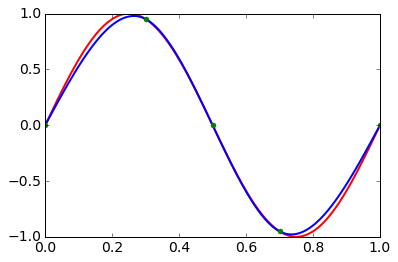

In [92]:
xs = np.array([0, .3, .5, .7, 1.]); ys = np.sin(2*np.pi*xs)
m = cubic_spline(xs, ys)
plt.plot(np.linspace(0, 1, 1000), np.sin(np.linspace(0, 2*np.pi, 1000)), 'r', lw=2)
for i in range(1, len(m)):
    x = np.linspace(xs[i-1], xs[i])
    plt.plot(x, hermite(ys[i-1], m[i-1], ys[i], m[i], xs[i-1], xs[i], x), 'b', lw=2)
plt.plot(xs, ys, 'g.', ms=10)
plt.show()